# Try inverse design of photoswitches


Let's still use the five bins we had for the forward task and then see if we ca generate valid SMILES.


In [119]:
%reload_ext autoreload
%autoreload 2

In [1]:
from gpt3forchem.data import get_photoswitch_data
from gpt3forchem.input import create_single_property_forward_prompts
from sklearn.model_selection import train_test_split
from gpt3forchem.api_wrappers import (
    fine_tune,
    query_gpt3,
    extract_prediction,
    ensemble_fine_tune,
    multiple_query_gpt3,
)
import time
from pycm import ConfusionMatrix
from gpt3forchem.baselines import GPRBaseline, compute_fragprints
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

plt.style.use(["science", "nature"])


/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = get_photoswitch_data()


We will also need to get the composition of the molecule to avoid that it doesn't only remember the wavelength


In [3]:
from rdkit import Chem

mol = Chem.AddHs(Chem.MolFromSmiles("C(=O)O"))
from collections import Counter

c = Counter(atom.GetSymbol() for atom in mol.GetAtoms())


In [4]:
data["SMILES"]


0                           C[N]1N=NC(=N1)N=NC2=CC=CC=C2
1                           C[N]1C=NC(=N1)N=NC2=CC=CC=C2
2                           C[N]1C=CC(=N1)N=NC2=CC=CC=C2
3                        C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2
4                           C[N]1C=C(C=N1)N=NC2=CC=CC=C2
                             ...                        
387    OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...
388    OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...
389    N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...
390    N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...
391    N#CC9C(SC(/N=N/C%10=NC(C=CC([N+]([O-])=O)=C%11...
Name: SMILES, Length: 392, dtype: object

Perhaps the best case for "inverse" design is to use the $\pi$-$\pi^*$ transition and the $n$-$\pi^*$ transition.
We simply will train on both and see if it can then answer a corresponding prompt.


In [5]:
PROMPT_TEMPLATE_w_n_pistar = "What is a molecule with a pi-pi* transition wavelength of {} nm and n-pi* transition wavelength of {} nm###"


In [6]:
PROMPT_TEMPLATE = "What is a molecule with a pi-pi* transition wavelength of {} nm###"


In [7]:
COMPLETION_TEMPLATE = "{}@@@"


In [8]:
prompts = []
completions = []

for i, row in data.iterrows():
    if np.isnan(row["E isomer n-pi* wavelength in nm"]):
        prompt = PROMPT_TEMPLATE.format(row["E isomer pi-pi* wavelength in nm"])
    else:
        prompt = PROMPT_TEMPLATE_w_n_pistar.format(
            row["E isomer pi-pi* wavelength in nm"],
            row["E isomer n-pi* wavelength in nm"],
        )

    completion = COMPLETION_TEMPLATE.format(row["SMILES"])
    prompts.append(prompt)
    completions.append(completion)


In [9]:
prompts = pd.DataFrame({"prompt": prompts, "completion": completions})


In [14]:
train_prompts, test_prompts = train_test_split(prompts, test_size=0.05, random_state=42)


In [15]:
train_size = len(train_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = (
    f"run_files/{filename_base}_train_prompts_photoswitch_inverse_{train_size}.jsonl"
)
test_filename = (
    f"run_files/{filename_base}_test_prompts_photoswitch_inverse_{train_size}.jsonl"
)


train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(test_filename, orient="records", lines=True)


In [16]:
fine_tune(train_filename, valid_file=test_filename)


Uploaded file from run_files/2022-09-01-22-40-59_train_prompts_photoswitch_inverse_372.jsonl: file-14E8ycJFulEto46gTf4pP61K
Uploaded file from run_files/2022-09-01-22-40-59_test_prompts_photoswitch_inverse_372.jsonl: file-ac3IcG3mrSZAOO2V7cHsJLC2
Created fine-tune: ft-ZH0U9kB3bF3ktLgCbn6xI51Y
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-09-01 22:41:15] Created fine-tune: ft-ZH0U9kB3bF3ktLgCbn6xI51Y

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-ZH0U9kB3bF3ktLgCbn6xI51Y

 
Upload progress:   0%|          | 0.00/57.8k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 57.8k/57.8k [00:00<00:00, 29.1Mit/s]

Upload progress:   0%|          | 0.00/3.13k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 3.13k/3.13k [00:00<00:00, 4.66Mit/s]



In [32]:
completions_1 = query_gpt3(
    "ada:ft-lsmoepfl-2022-09-01-21-01-50", test_prompts, max_tokens=80, temperature=1.0
)


In [105]:
completions_15 = query_gpt3(
    "ada:ft-lsmoepfl-2022-09-01-21-01-50", test_prompts, max_tokens=80, temperature=1.5
)


In [42]:
test_prompts.iloc[0]["prompt"]


'What is a molecule pi-pi* transition wavelength of 321.0 nm and n-pi* transition wavelength of 424.0 nm###'

In [22]:
completions_argmax = completions


In [70]:
data[data["SMILES"] == "C1=CC=C(/N=N/C2=CC=C(NCCC#N)C=C2)C=C1"]


,index,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,...,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm,name,selfies,wavelength_cat


In [33]:
completions_1


{'choices': [<OpenAIObject at 0x2a1eb1180> JSON: {
    "finish_reason": "length",
    "index": 0,
    "logprobs": null,
    "text": "CC1=C(/N=N/C2=CC(F)=CC=C2)C(C)=NO1@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@"
  },
  <OpenAIObject at 0x2a1ea7d60> JSON: {
    "finish_reason": "length",
    "index": 1,
    "logprobs": null,
    "text": "[H]C6=CC=C(N=C(N=NC7=CC=CC=C7S8S9)T8)C8=C6@@@N#N=C7@@@N#C[H]C=C8@@@C8@@@C@@@C9@@@C@@@C@@@C@@@"
  },
  <OpenAIObject at 0x2a1ea7a90> JSON: {
    "finish_reason": "length",
    "index": 2,
    "logprobs": null,
    "text": "CCN(CCC#N)C(C=C%22)=CC=C%22/N=N/C%23=CC(OC)=CC=C%23@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@"
  },
  <OpenAIObject at 0x2a1ea75e0> JSON: {
    "finish_reason": "length",
    "index": 3,
    "logprobs": null,
    "text": "FC1=CC=CC(F)=C1/N=N/C2=CC=CC=C2@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@"
  },
  <OpenAIObject at 0x2a1e42f40> JSON: 

## Let's train models that can predict the wavelengths.


In [43]:
fragprints = compute_fragprints(data["SMILES"].values)


In [45]:
pi_pi_star_model = GPRBaseline()
pi_pi_star_model.fit(fragprints, data["E isomer pi-pi* wavelength in nm"].values)


/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-09-02 07:56:44.010873: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -0.03669 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 39.794   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.02808 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [73]:
import joblib


In [74]:
joblib.dump(pi_pi_star_model, "../models/pi_pi_star_model.joblib")


['../models/pi_pi_star_model.joblib']

In [52]:
n_pi_star_model = GPRBaseline()
n_pi_star_model.fit(
    fragprints[data[~data["E isomer n-pi* wavelength in nm"].isna()].index.values],
    data["E isomer n-pi* wavelength in nm"].values[
        data[~data["E isomer n-pi* wavelength in nm"].isna()].index.values
    ],
)


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │  1.87032 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 35.2361  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.11178 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [75]:
joblib.dump(n_pi_star_model, "../models/n_pi_star_model.joblib")


['../models/n_pi_star_model.joblib']

In [54]:
def predict(smiles):
    fragprints = compute_fragprints([smiles])
    return (
        pi_pi_star_model.predict(fragprints)[0],
        n_pi_star_model.predict(fragprints)[0],
    )


In [71]:
predict("C1=CC=C(/N=N/C2=CC=C(NCCC#N)C=C2)C=C1")


(array([390.91004025]), array([446.54990223]))

In [72]:
test_prompts["prompt"].values[-2]


'What is a molecule pi-pi* transition wavelength of 404.0 nm###'

### Let's now do a more systematic analysis


Let's look at how well it does in generating SMILES of photoswitches.


In [91]:
from gpt3forchem.output import (
    is_valid_smiles,
    predict_photoswitch,
    is_string_in_training_data,
)
from gpt3forchem.api_wrappers import extract_inverse_prediction


In [89]:
train_smiles = (
    train_prompts["completion"].apply(lambda x: x.replace("@@@", "")).to_list()
)


In [106]:
argmax_predictions = [
    extract_inverse_prediction(completions_argmax, i)
    for i in range(len(completions_argmax["choices"]))
]
t_05_predictions = [
    extract_inverse_prediction(completions_05, i)
    for i in range(len(completions_05["choices"]))
]
t_1_predictions = [
    extract_inverse_prediction(completions_1, i)
    for i in range(len(completions_1["choices"]))
]
t_15_predictions = [
    extract_inverse_prediction(completions_15, i)
    for i in range(len(completions_15["choices"]))
]


In [107]:
argmax_valid_smiles = [is_valid_smiles(smiles) for smiles in argmax_predictions]
t_05_valid_smiles = [is_valid_smiles(smiles) for smiles in t_05_predictions]
t_1_valid_smiles = [is_valid_smiles(smiles) for smiles in t_1_predictions]
t_15_valid_smiles = [is_valid_smiles(smiles) for smiles in t_15_predictions]


[09:48:28] Explicit valence for atom # 8 O, 3, is greater than permitted
[09:48:28] SMILES Parse Error: syntax error while parsing: [H]C6=CC=C(N=C(N=NC7=CC=CC=C7S8S9)T8)C8=C6
[09:48:28] SMILES Parse Error: Failed parsing SMILES '[H]C6=CC=C(N=C(N=NC7=CC=CC=C7S8S9)T8)C8=C6' for input: '[H]C6=CC=C(N=C(N=NC7=CC=CC=C7S8S9)T8)C8=C6'
[09:48:28] SMILES Parse Error: syntax error while parsing: CC(C=C(N(CCC#N)CCC#N)C=C1)=C1/N=N/C2=CC(K)=CC=C2Cl
[09:48:28] SMILES Parse Error: Failed parsing SMILES 'CC(C=C(N(CCC#N)CCC#N)C=C1)=C1/N=N/C2=CC(K)=CC=C2Cl' for input: 'CC(C=C(N(CCC#N)CCC#N)C=C1)=C1/N=N/C2=CC(K)=CC=C2Cl'
[09:48:28] SMILES Parse Error: syntax error while parsing: R`C(C=C1)=CC=C1N=NC2=NNC=C2
[09:48:28] SMILES Parse Error: Failed parsing SMILES 'R`C(C=C1)=CC=C1N=NC2=NNC=C2' for input: 'R`C(C=C1)=CC=C1N=NC2=NNC=C2'
[09:48:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[09:48:28] SMILES Parse Error: syntax error while parsing: 1N#CC([N+]([O-])=O)=CC(C#N)=C1/N=N/C2=CC([H])=C(C=C2[H])N(CC

In [108]:
print("Fractions of valid SMILES:")
print("========================")
print("argmax: {}".format(np.mean(argmax_valid_smiles)))
print("t_05: {}".format(np.mean(t_05_valid_smiles)))
print("t_1: {}".format(np.mean(t_1_valid_smiles)))
print("t_15: {}".format(np.mean(t_15_valid_smiles)))


Fractions of valid SMILES:
argmax: 1.0
t_05: 0.95
t_1: 0.75
t_15: 0.1


In [109]:
argmax_smiles_in_train = [
    is_string_in_training_data(smiles, train_smiles)
    for smiles in np.array(argmax_predictions)[argmax_valid_smiles]
]
t_05_smiles_in_train = [
    is_string_in_training_data(smiles, train_smiles)
    for smiles in np.array(t_05_predictions)[t_05_valid_smiles]
]
t_1_smiles_in_train = [
    is_string_in_training_data(smiles, train_smiles)
    for smiles in np.array(t_1_predictions)[t_1_valid_smiles]
]
t_15_smiles_in_train = [
    is_string_in_training_data(smiles, train_smiles)
    for smiles in np.array(t_15_predictions)[t_15_valid_smiles]
]


In [110]:
print("Fractions of valid SMILES in training data:")
print("============================================")
print("argmax: {}".format(np.mean(argmax_smiles_in_train)))
print("t_05: {}".format(np.mean(t_05_smiles_in_train)))
print("t_1: {}".format(np.mean(t_1_smiles_in_train)))
print("t_15: {}".format(np.mean(t_15_smiles_in_train)))


Fractions of valid SMILES in training data:
argmax: 1.0
t_05: 0.7368421052631579
t_1: 0.4
t_15: 0.5


In [120]:
valid_argmax_smiles = np.array(argmax_predictions)[argmax_valid_smiles]
valid_t_05_smiles = np.array(t_05_predictions)[t_05_valid_smiles]
valid_t_1_smiles = np.array(t_1_predictions)[t_1_valid_smiles]
valid_t_15_smiles = np.array(t_15_predictions)[t_15_valid_smiles]


In [134]:
argmax_pi_pi_star, argmax_n_pi_star = predict_photoswitch(valid_argmax_smiles)
t_05_pi_pi_star, t_05_n_pi_star = predict_photoswitch(valid_t_05_smiles)
t_1_pi_pi_star, t_1_n_pi_star = predict_photoswitch(valid_t_1_smiles)
t_15_pi_pi_star, t_15_n_pi_star = predict_photoswitch(valid_t_15_smiles)


In [135]:
test_prompts["prompt"].values[0]


'What is a molecule pi-pi* transition wavelength of 321.0 nm and n-pi* transition wavelength of 424.0 nm###'

In [139]:
from gpt3forchem.output import get_expected_wavelengths, get_regression_metrics


In [140]:
expected_pi_pi_star, expected_n_pi_star = [], []

for prompt in test_prompts["prompt"].values:
    pi_pi_star, n_pi_star = get_expected_wavelengths(prompt)
    expected_pi_pi_star.append(pi_pi_star)
    expected_n_pi_star.append(n_pi_star)

expected_pi_pi_star = np.array(expected_pi_pi_star)
expected_n_pi_star = np.array(expected_n_pi_star)


In [145]:
get_regression_metrics(expected_pi_pi_star[argmax_valid_smiles], argmax_pi_pi_star)


{'r2': 0.3464112321589137,
 'max_error': 133.5998863689873,
 'mean_absolute_error': 29.93002272620189,
 'mean_squared_error': 2051.5808288428584}

In [146]:
get_regression_metrics(expected_pi_pi_star[t_05_valid_smiles], t_05_pi_pi_star)


{'r2': -0.4248960029180302,
 'max_error': 146.45797892327198,
 'mean_absolute_error': 46.8321830192999,
 'mean_squared_error': 4464.479419846363}

In [147]:
get_regression_metrics(expected_pi_pi_star[t_1_valid_smiles], t_1_pi_pi_star)


{'r2': -0.382265511212019,
 'max_error': 167.76807688023155,
 'mean_absolute_error': 42.85388470075084,
 'mean_squared_error': 4690.094456967374}

In [148]:
get_regression_metrics(expected_pi_pi_star[t_15_valid_smiles], t_15_pi_pi_star)


{'r2': -111.15621599913116,
 'max_error': 34.993874515941286,
 'mean_absolute_error': 31.588074848198374,
 'mean_squared_error': 1009.4059439921805}

In [155]:
has_expected_n_pi_star = np.array(
    [n_pi_star is not None for n_pi_star in expected_n_pi_star]
)


In [159]:
get_regression_metrics(
    expected_n_pi_star[argmax_valid_smiles & has_expected_n_pi_star],
    argmax_n_pi_star[argmax_valid_smiles & has_expected_n_pi_star],
)


{'r2': -1.069562347103199,
 'max_error': 76.87946170929854,
 'mean_absolute_error': 29.75297447286569,
 'mean_squared_error': 1595.230154715741}

In [191]:
get_regression_metrics(
    expected_n_pi_star[t_05_valid_smiles & has_expected_n_pi_star],
    np.array(t_05_n_pi_star)[[has_expected_n_pi_star[i] for i in range(len(t_05_valid_smiles)) if t_05_valid_smiles[i]]],
)


{'r2': -0.7374912707834655,
 'max_error': 76.02897558950963,
 'mean_absolute_error': 28.828626041353413,
 'mean_squared_error': 1591.264005434329}

In [193]:
get_regression_metrics(
    expected_n_pi_star[t_1_valid_smiles & has_expected_n_pi_star],
    np.array(t_1_n_pi_star)[[has_expected_n_pi_star[i] for i in range(len(t_1_valid_smiles)) if t_1_valid_smiles[i]]],
)


{'r2': -0.8863811493339613,
 'max_error': 73.06108770027743,
 'mean_absolute_error': 30.095921143812422,
 'mean_squared_error': 1454.0330698018915}

In [210]:
from gpt3forchem.output import get_similarity_to_train_mols, aggregate_array

In [215]:
aggregate_array(get_similarity_to_train_mols(valid_t_15_smiles[0], train_smiles))

{'min': 0.10047846889952153,
 'max': 0.7279151943462897,
 'mean': 0.24734720827842052,
 'std': 0.08267809355267454}

In [216]:
aggregate_array(get_similarity_to_train_mols(valid_t_15_smiles[1], train_smiles))

{'min': 0.06049149338374291,
 'max': 1.0,
 'mean': 0.2987032001536834,
 'std': 0.1527567331812793}

Let's wrap this all up in one function call


In [219]:
from gpt3forchem.output import test_inverse_photoswitch

In [231]:
test_inverse_photoswitch(
    test_prompts, "ada:ft-lsmoepfl-2022-09-01-21-01-50", train_smiles, temperature=1.5
)


[14:51:38] SMILES Parse Error: unclosed ring for input: 'FC1=CC(F)=CC=C1/N=N/C2=CC=CC(C#3)=C2'
[14:51:38] SMILES Parse Error: syntax error while parsing: FC(sup-(7),Fc8=fa)C=CC=C1/N=N/C9=CC=C([N+]([O-])=O)C=C9
[14:51:38] SMILES Parse Error: Failed parsing SMILES 'FC(sup-(7),Fc8=fa)C=CC=C1/N=N/C9=CC=C([N+]([O-])=O)C=C9' for input: 'FC(sup-(7),Fc8=fa)C=CC=C1/N=N/C9=CC=C([N+]([O-])=O)C=C9'
[14:51:38] SMILES Parse Error: syntax error while parsing: 451
[14:51:38] SMILES Parse Error: Failed parsing SMILES '451' for input: '451'
[14:51:38] SMILES Parse Error: syntax error while parsing: ON[N+]([O-])C1=C(NOC)C2=CC=C(/N=N/C3=C(S)C(SCC3OC3))(WS1)=WS2
[14:51:38] SMILES Parse Error: Failed parsing SMILES 'ON[N+]([O-])C1=C(NOC)C2=CC=C(/N=N/C3=C(S)C(SCC3OC3))(WS1)=WS2' for input: 'ON[N+]([O-])C1=C(NOC)C2=CC=C(/N=N/C3=C(S)C(SCC3OC3))(WS1)=WS2'
[14:51:38] SMILES Parse Error: unclosed ring for input: 'ClC1=CC([N+]([O-])=O)=CC(SC)=C1/N=N/C2=C21'
[14:51:38] SMILES Parse Error: unclosed ring for input: '

{'meta': {'temperature': 1.5,
  'max_tokens': 80,
  'model': 'ada:ft-lsmoepfl-2022-09-01-21-01-50'},
 'predictions': array(['FC1=CC(F)=CC=C1/N=N/C2=CC=CC(C#3)=C2 Tickets:(C#3)R=R1 Felides([nistropicallyN^2]JimmyHC=N)ldonith(F)=N',
        'FC(sup-(7),Fc8=fa)C=CC=C1/N=N/C9=CC=C([N+]([O-])=O)C=C9 spontou n ## Oklahoma Second Only Tube$Oc%9n(Sc%9 minsCCChgousC%9 cc%9)ssWords$O Outgo',
        '451 CNoCncr1(s ordainedsin[s1]ccn2)c(c2 transitional112fs)c2(nb2::N Change engine2300ccnownc252)-- Usn Baby[nls1]oooooooooC#N<br>Chgard (etgen)jpg257.....{{OlJJBrCroomhcm2Cla2Br',
        'FC1=CC=CC(F)=C1/N=N/C 2=C(DT)C=CC=C2',
        'ON[N+]([O-])C1=C(NOC)C2=CC=C(/N=N/C3=C(S)C(SCC3OC3))(WS1)=WS2',
        'ClC1=CC([N+]([O-])=O)=CC(SC)=C1/N=N/C2=C21 libertarian/N=N/C3A=((O){N+}=O) bendcatrcatsnn(C=C3)Cy6ntmt VT=CC([N+]([O-])=O)=',
        'C[N]1C=NC(=N1)N=NC2=CC=CC=C2',
        'FC1=CC(/N=N/C2=C/C=C([N+]([O-])=O)=CCC)=C1 chilling away',
        'Rh(C) hundred-n-number tonic atance bar*=]C1=CC(/N=N/

In [232]:
from rdkit import Chem

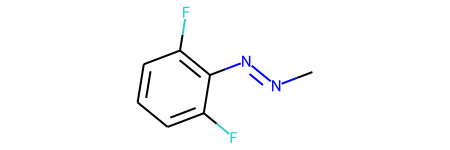

In [234]:
Chem.MolFromSmiles('FC1=CC=CC(F)=C1/N=N/C')